In [1]:
import qutip, pickle, sys
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import time as time
import math, cmath
import auxiliary_library as me

from IPython.display import display, Math, Latex
np.set_printoptions(threshold=1.e-9,linewidth=120,precision=3, suppress=True, formatter={"float":lambda x: str(.001*int(1000*x))})

In [25]:
N = 2; k_B = 1; temp = 1e2; temp_ref = 1e0
spin_ops_list = me.one_body_spin_ops(N)
identity_op = spin_ops_list[0][0]

chain_type = "XYZ"; Hamiltonian_paras = [.2, .15, .1, 1.]

### construcción de los operadores
spin_ops_list = me.one_body_spin_ops(N)
identity_op = spin_ops_list[0][0]
ts = np.linspace(0, 50,700)  

### Heisenberg Hamiltonian & classical operators
H_H = me.Heisenberg_Hamiltonian(op_list = spin_ops_list, chain_type = chain_type,
                                size = N, Hamiltonian_paras = Hamiltonian_paras,
                                closed_bcs = True, visualization = False)

cl_ops, label_ops = me.classical_ops(H_H, N, spin_ops_list, False)
magnetization = sum(spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))
neel_operator = sum((-1)**a * spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))

cl_ops["magnetization"] = magnetization; label_ops.append("magnetization")
cl_ops["neel_op"] = neel_operator; label_ops.append("neel_op")
print("Are all the operators Hermitian?:", me.basis_hermitian_check(cl_ops))

### Base completa

zero_body_ops = spin_ops_list[0]
one_body_ops = [op for op in spin_ops_list[1]+spin_ops_list[2]+spin_ops_list[3]]
two_body_ops = [op1 * op2 for op1 in one_body_ops for op2 in one_body_ops]
depth_and_seed_ops = [(1,op) for op in (zero_body_ops+one_body_ops+two_body_ops)]
print(len(depth_and_seed_ops))

Are all the operators Hermitian?: [True, True, True, True, True, True, True, True, True, True]
43


using a base of size  6
rho_ref:  Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.52 0.0 0.0 0.005]
 [0.0 0.451 0.033 0.0]
 [0.0 0.033 0.013000000000000001 0.0]
 [0.005 0.0 0.0 0.013000000000000001]]
The basis is orthonormal and hermitian
rho_0:  Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.42 +0.j     0.   +0.j     0.   +0.j    -0.   +0.012j]
 [ 0.   +0.j     0.546+0.j    -0.001+0.027j  0.   +0.j   ]
 [ 0.   +0.j    -0.001-0.027j  0.021+0.j     0.   +0.j   ]
 [-0.   -0.012j  0.   +0.j     0.   +0.j     0.013+0.j   ]]
Proj ev runtime =  5.565575122833252
Exact ev runtime =  0.08949971199035645


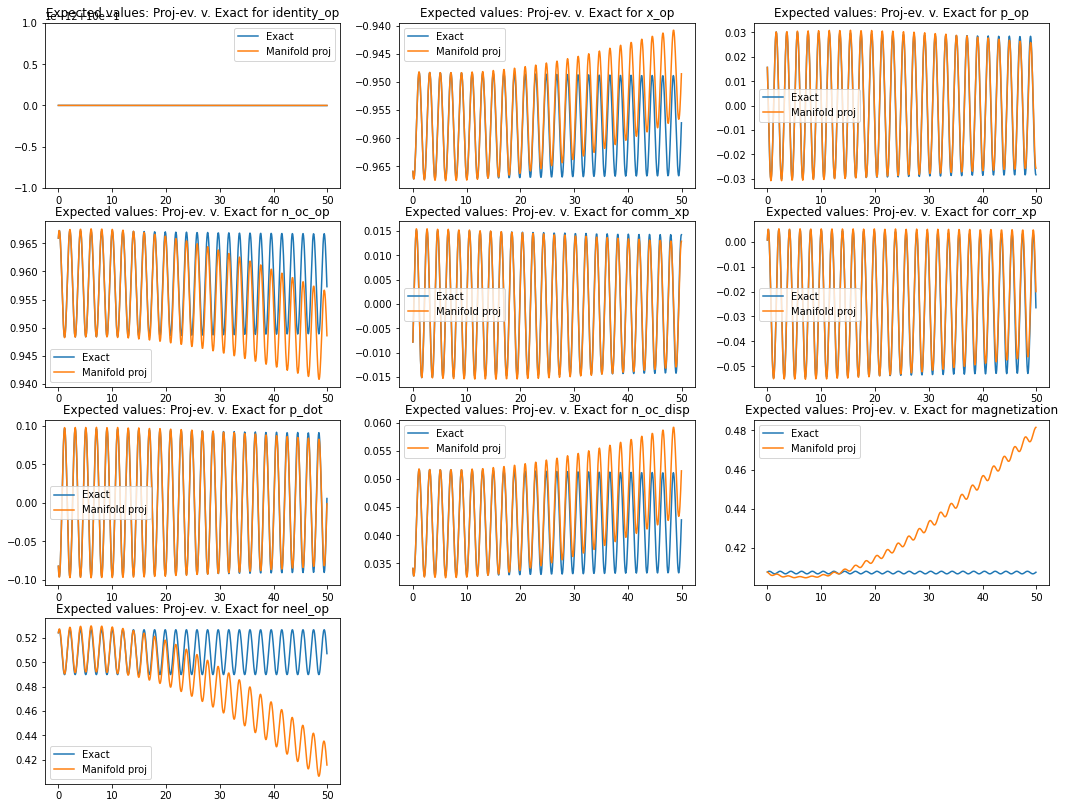

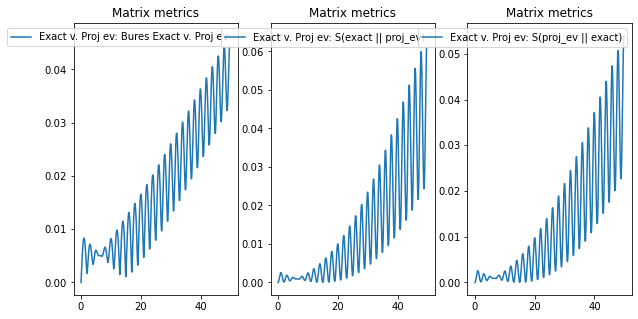

In [45]:
depth_and_seed_ops = [(1, cl_ops["identity_op"]), 
                      (1, H_H), 
                      (4, cl_ops["x_op"])]
coeff_list = [0., .5, .25, .125, .125, .057]

observables = list(cl_ops.values())
Gram_matrix, rho0, dict_res_proj_ev, res_exact, basis_orth = me.d_depth_proj_ev(
    temp_ref = temp_ref, temp_rho = temp, timespan = ts, 
    Hamiltonian = H_H, lagrange_op = cl_ops["n_oc_disp"],
    depth_and_seed_ops = depth_and_seed_ops, observables = observables, 
    label_ops = label_ops, coeff_list = coeff_list, 
    visualize_H_evs = False, visualization_nonherm = False, visualize_expt_vals = True
)